# Introduction to Fugue (10 mins)

[![Slack Status](https://img.shields.io/badge/slack-join_chat-white.svg?logo=slack&style=social)](http://slack.fugue.ai)

[Fugue](https://github.com/fugue-project/fugue/) is an open-source project that aims to simplify distributed computing. The simplest interface is the `transform()` function.

<img src="https://fugue-tutorials.readthedocs.io/_images/fugue_backends.png" align="left" width="700"/>

## Core Ideas Behind Fugue

* Minimizing dependence on frameworks and infrastructure
* Iterate on local as much as possible before worrying about scale
* Let users use the tools they already know and adjust to them

## How is Fugue Different From?

**Drop-in Pandas replacements (Modin and Pandas API on Spark)**

There are drop-in replacements for Pandas that suggests users simply change the import. Fugue believes Pandas is great in the local setting, but [suboptimal as the grammar for distributed computing](https://towardsdatascience.com/why-pandas-like-interfaces-are-sub-optimal-for-distributed-computing-322dacbce43). This is due to assumptions like having data all on the same machine (`index`, `iloc`, `loc`). Spark has no index. Second, let's think of Dask. Dask prevents certain operations like `df.iloc[10, [2,3]]`. Why does Dask do that? It's because not all operations translate well, and Pandas can prevent us from having the right mindset.

**Ibis**

Ibis is a Python interface that wraps on top of SQLAlchemy. It does support different backends, but one of the biggest differences is that Fugue is not confined to the SQL semantics. It also facilitates as a bridge between local and distributed computing. In order to do this, we need consistency between backends and we write the extra code to do so.

Below is a table of some inconsistencies:

![img](https://miro.medium.com/v2/resize:fit:1400/0*fv0FKyt3jB0ehVrU)

## First Look at Fugue

The simplest way Fugue can be used to scale Pandas based code to Spark or Dask is the `transform()` function. In the example below, we’ll train a model using scikit-learn and pandas, and then perform the inference parallelized on top of the Spark execution engine.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

X = pd.DataFrame({"x_1": [1, 1, 2, 2], "x_2":[1, 2, 2, 3]})
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)

In [2]:
def predict(df: pd.DataFrame, model: LinearRegression) -> pd.DataFrame:
    return df.assign(predicted=model.predict(df))

input_df = pd.DataFrame({"x_1": [3, 4, 6, 6], "x_2":[3, 3, 6, 6]})
predict(input_df.copy(), reg)

,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


In [3]:
from fugue import transform

result = transform(
    input_df,
    predict,
    schema="*,predicted:double",
    params=dict(model=reg),
)
print(type(result))
result.head()

<class 'pandas.core.frame.DataFrame'>


,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


**Spark**

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

result = transform(
    input_df,
    predict,
    schema="*,predicted:double",
    params=dict(model=reg),
    engine=spark
)
print(type(result))
result.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/24 21:34:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/24 21:34:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/24 21:34:05 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/04/24 21:34:05 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
<class 'pyspark.sql.dataframe.DataFrame'>
+---+---+---------+
|x_1|x_2|predicted|
+---+---+---------+
|  3|  3|     12.0|
|  4|  3|     13.0|
|  6|  6|     21.0|
|  6|  6|     21.0|
+---+---+---------+



## Equivalent Spark Code

How would we bring this to PySpark if Fugue didn't exist? Below is one way, some of the annotations are also required. The Schema is a much heaver expression (specific to PySpark)

In [9]:
from typing import Iterator, Union
from pyspark.sql.types import StructType, DoubleType
from pyspark.sql import DataFrame

def prediction_wrapper(dfs: Iterator[pd.DataFrame], model):
  for df in dfs:
      yield predict(df, model)

def run_predict(input_df: Union[DataFrame, pd.DataFrame], model):
  # conversion
  if isinstance(input_df, pd.DataFrame):
      sdf = spark.createDataFrame(input_df.copy())
  else:
      sdf = input_df.copy()

  schema = StructType(list(sdf.schema.fields))
  schema.add("predicted", DoubleType())
  return sdf.mapInPandas(lambda dfs: prediction_wrapper(dfs, model),
                          schema=schema)

result = run_predict(input_df, reg)
result.show()

+---+---+---------+
|x_1|x_2|predicted|
+---+---+---------+
|  3|  3|     12.0|
|  4|  3|     13.0|
|  6|  6|     21.0|
|  6|  6|     21.0|
+---+---+---------+



## Quick Peek at Fugue SQL

This is the only FugueSQL part of the tutorial. We'll just show a quick preview. The FugueSQL API is 1:1 with the Python API. Instead of having SQL code sandwiched between Python code, we elevate SQL to a first-class programming interface capable of expressing end-to-end workflows. We can also invoke Python functions as we'll see.

In [10]:
from fugue_jupyter import setup
setup()

In [12]:
%%fsql 
SELECT *
  FROM input_df
 PRINT

,x_1:long,x_2:long
0,3,3
1,4,3
2,6,6
3,6,6


In [19]:
# schema: *, predicted:double
def predict_sql(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(predicted=reg.predict(df))

In [20]:
%%fsql 
SELECT *
  FROM input_df
TRANSFORM USING predict_sql
 PRINT

,x_1:long,x_2:long,predicted:double
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


In [24]:
from fugue.api import fugue_sql

query = """
SELECT *
  FROM input_df
TRANSFORM USING predict_sql
"""

res = fugue_sql(query, engine=spark)
print(type(res))
res.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+---+---+---------+
|x_1|x_2|predicted|
+---+---+---------+
|  3|  3|     12.0|
|  4|  3|     13.0|
|  6|  6|     21.0|
|  6|  6|     21.0|
+---+---+---------+



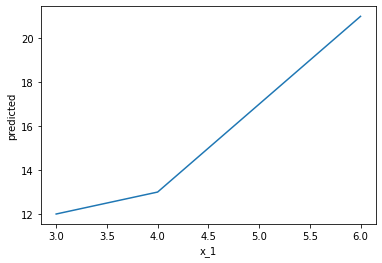

In [25]:
%%fsql 
SELECT *
  FROM input_df
TRANSFORM USING predict_sql
OUTPUT USING sns:lineplot(x="x_1",y="predicted")